## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
def region_selection(image):
    '''Determine and cut the region of interest in the input image.'''
    mask = np.zeros_like(image)
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        # We could have used fixed numbers as the vertices of the polygon,
        # but they will not be applicable to images with different dimensions.
    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image


In [2]:
import glob
from preprocessing import *
import os

In [3]:
nx, ny = (9,6)

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')

In [5]:
objpoints, imgpoints = get_img_obj_points(images, nx, ny)

In [6]:
create_pickle_file(objpoints, imgpoints)

In [7]:
dist_pickle = pickle.load( open( "wide_dist.pickle", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

In [8]:
test_images = []
for image in glob.glob('test_images/*.jpg'):
    test_images.append(image)

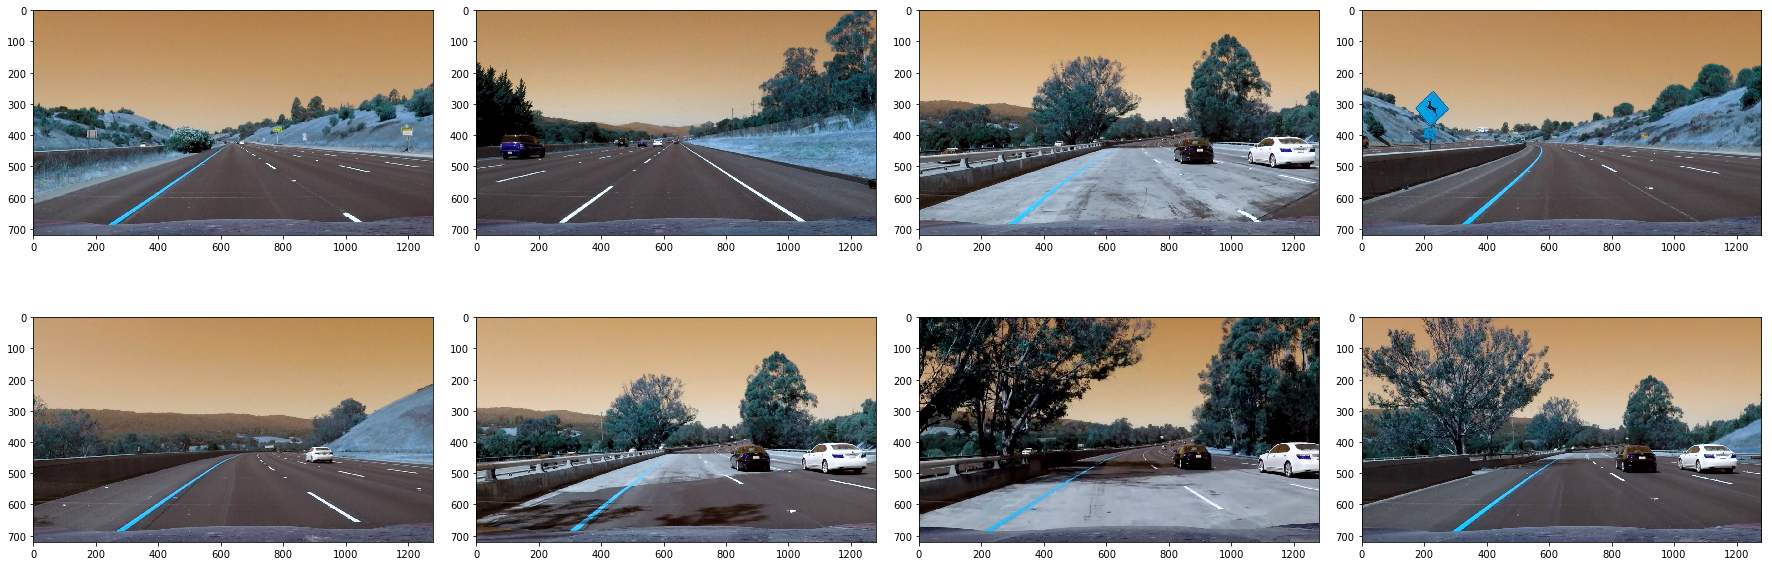

In [9]:
f, (ax1, ax2) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
half = len(test_images)//2
for i in range(len(test_images)//2):
    ax1[i].imshow(cv2.imread(test_images[i]))
    ax2[i].imshow(cv2.imread(test_images[half + i]))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Undistort Images

In [10]:
for image in test_images:
    img = cv2.imread(image)
    img = np.copy(img)
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(img, objpoints, imgpoints)
    img = undistort_image(img, mtx, dist)
    cv2.imshow('img', img)
    file_img = image.split('/')[1]
    file_path = os.path.join('output_images/undistorted_images/',file_img)
    cv2.imwrite(file_path, img)

In [11]:
undistorted_images = []
for image in glob.glob('output_images/undistorted_images/*.jpg'):
    undistorted_images.append(image)

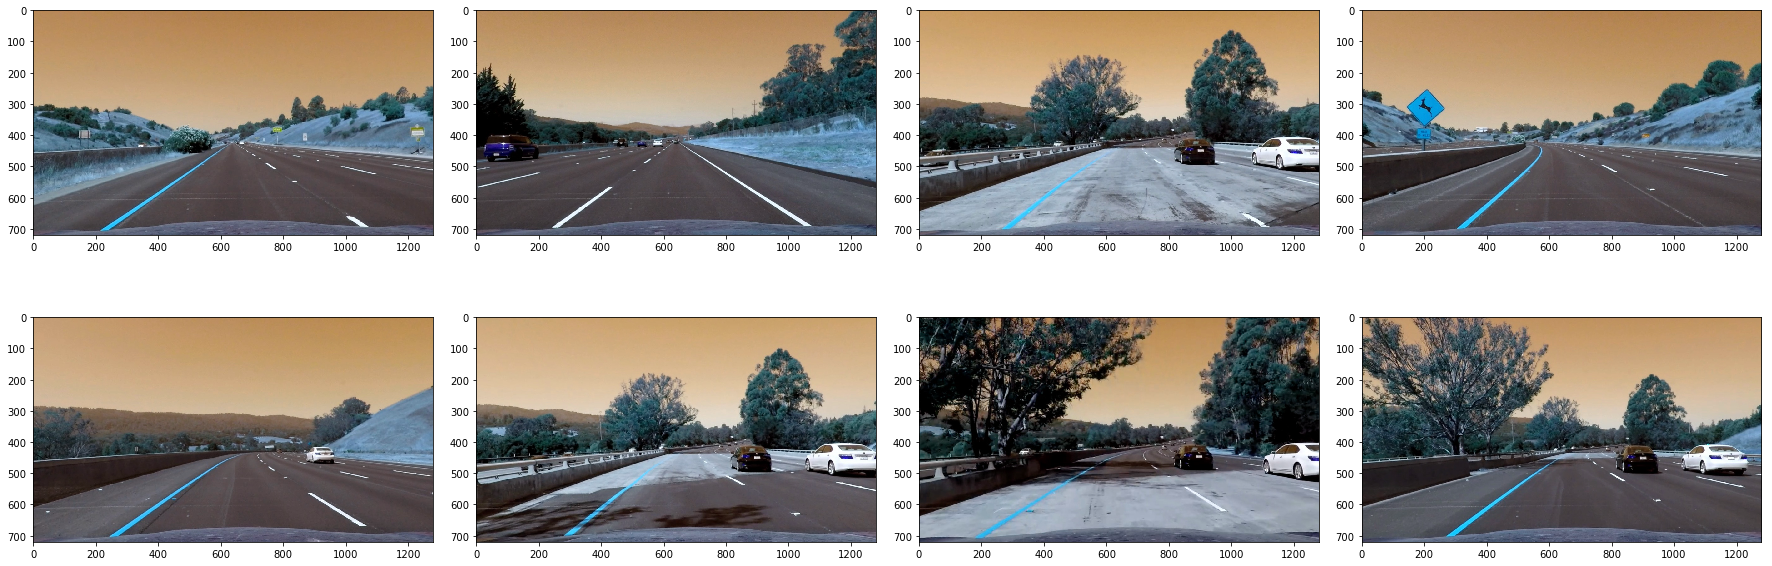

In [12]:
f, (ax1, ax2) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
half = len(undistorted_images)//2
for i in range(len(undistorted_images)//2):
    ax1[i].imshow(cv2.imread(undistorted_images[i]))
    ax2[i].imshow(cv2.imread(undistorted_images[half + i]))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Color Transform and gradient transform

In [13]:
## 1 - RGB CHANNEL TRANFORM
## 2 - HSL CHANNEL TRANSFORM
## 3 - Sobelx transform
## 4 - Sobel y transform
## 4 

In [14]:
for image in undistorted_images:
    img = cv2.imread(image)
    img = np.copy(img)
    #img = region_selection(img)
    img = pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100))
    file_img = image.split('/')[2]
    
    file_path = os.path.join('output_images/transform/',file_img)
    cv2.imwrite(file_path, img)
    

In [15]:
transformed_images = []
for image in glob.glob('output_images/transform/*.jpg'):
    transformed_images.append(image)

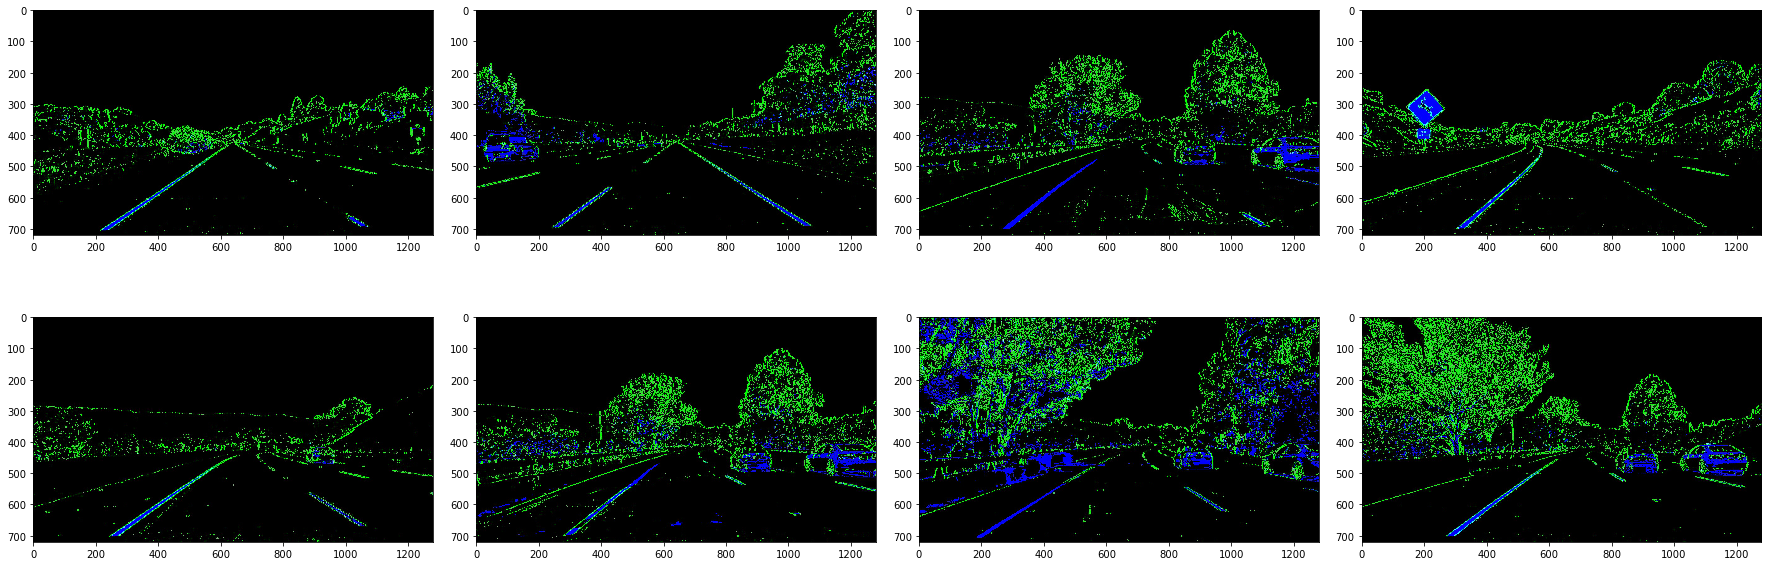

In [16]:
f, (ax1, ax2) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
half = len(transformed_images)//2
for i in range(len(transformed_images)//2):
    ax1[i].imshow(cv2.imread(transformed_images[i]))
    ax2[i].imshow(cv2.imread(transformed_images[half + i]))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Perspective Transform

In [17]:
offset = 100
for image in transformed_images:
    img = cv2.imread(image)
    img = np.copy(img)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([imgpoints[0][0], imgpoints[0][nx-1], imgpoints[0][-1], imgpoints[0][-nx]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], \
                    [img_size[0]-offset, img_size[1]-offset], \
                    [offset, img_size[1]-offset]])
    transform = perspective_transform(src, dst)
    warped = warp_image(img, transform, img_size, flags=cv2.INTER_LINEAR)
    
    file_img = image.split('/')[2]
    
    file_path = os.path.join('output_images/warped_images/',file_img)
    cv2.imwrite(file_path, img)
    




In [18]:
warped_images = []
for image in glob.glob('output_images/warped_images/*.jpg'):
    warped_images.append(image)

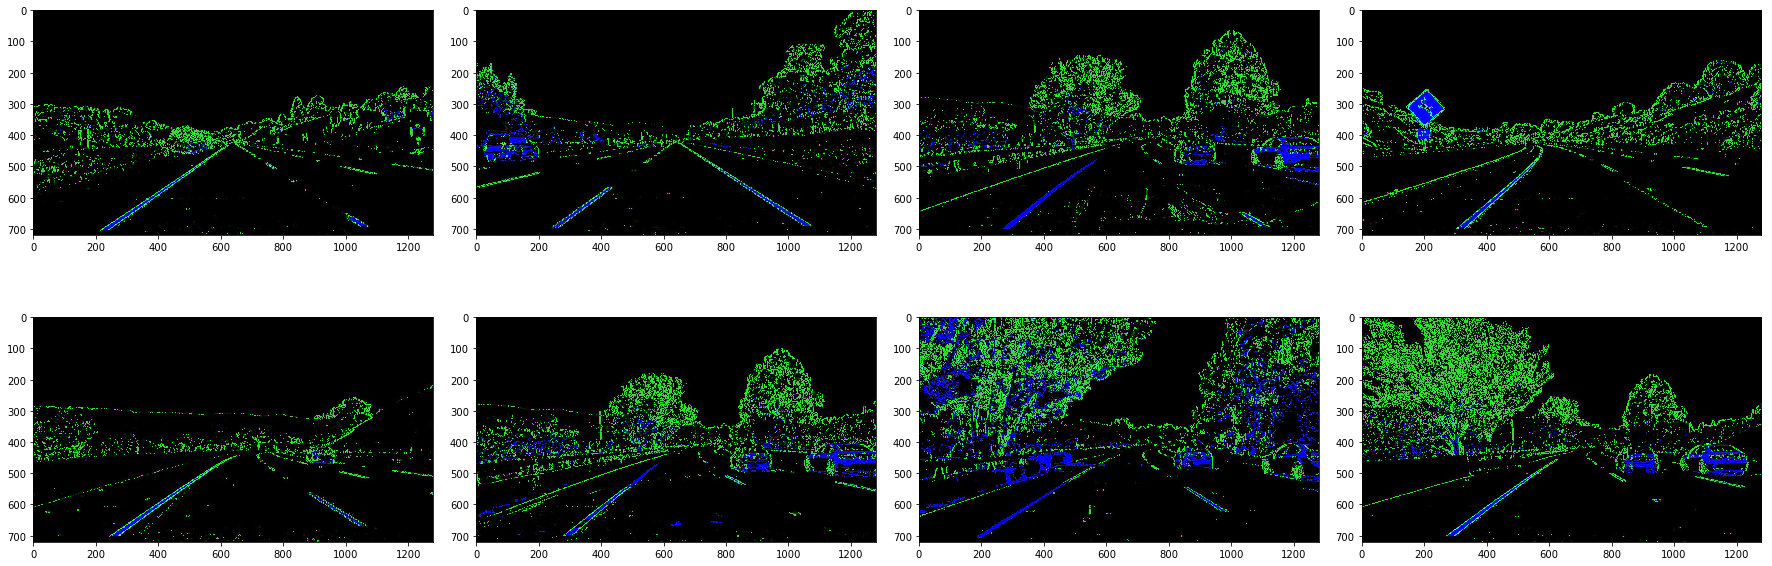

In [19]:
f, (ax1, ax2) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
half = len(warped_images)//2
for i in range(len(warped_images)//2):
    ax1[i].imshow(cv2.imread(warped_images[i]))
    ax2[i].imshow(cv2.imread(warped_images[half + i]))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Detect lane pixels and fit to find the lane boundary

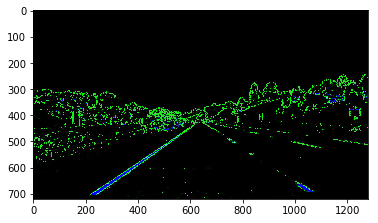

In [20]:
img_path = transformed_images[0]

img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

In [22]:
img.shape

(720, 1280, 3)

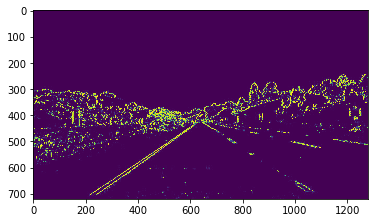

In [26]:
s_channel = img[:, :, 1]
plt.imshow(s_channel)
plt.show()

In [24]:
img = region_selection(s_channel)

In [26]:
img.shape

(720, 1280)

In [27]:
im = region_selection(img)

In [32]:
s_channel.shape

(720, 1280)

hello
[  0   1   2 ..., 196 197 200]
[560 560 560 ..., 319 319 319]


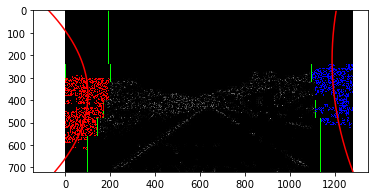

hello
[ 32  33  34 ..., 140 141 142]
[708 708 708 ..., 239 239 239]


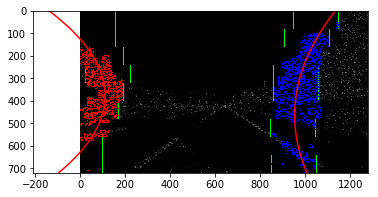

hello
[  1   2   3 ..., 189 190 191]
[640 640 640 ..., 319 319 319]


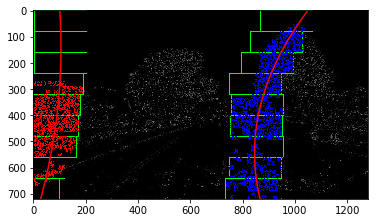

hello
[ 69  70  71 ..., 177 178 183]
[640 640 640 ..., 319 319 319]


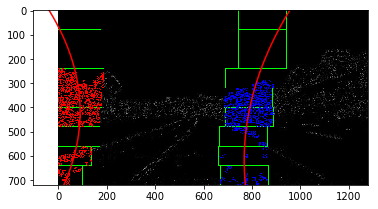

hello
[ 80  89  90 ..., 154 157 158]
[688 688 688 ..., 319 319 319]


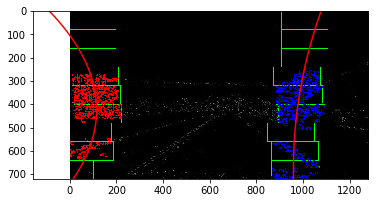

hello
[  1   7   8 ..., 121 125 126]
[640 640 640 ..., 319 319 319]


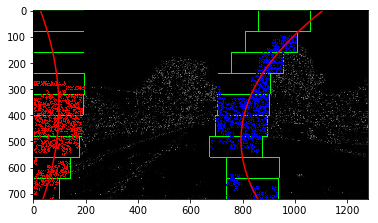

hello
[ 87  88  89 ..., 194 197 198]
[576 576 576 ...,  79  79  79]


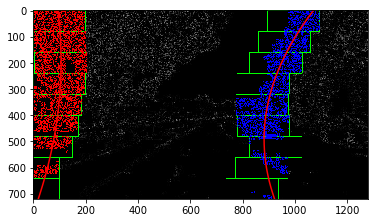

hello
[ 98  96  97 ..., 188 193 196]
[561 562 562 ...,  79  79  79]


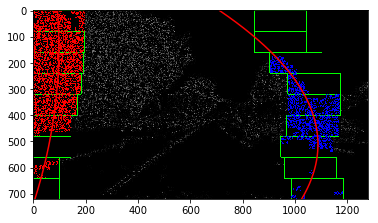

In [29]:
for image in transformed_images:
    img = cv2.imread(image)
    binary_warped = np.copy(img)
    s_channel = binary_warped[:, :, 0]
    img = fit_polynomial(s_channel)
    file_img = image.split('/')[2]
    file_path = os.path.join('output_images/lane_detection/',file_img)
    cv2.imwrite(file_path, img)

### Determine the curvature of the lane and vehicle position with respect to center

### Warp the detected lane boundaries back onto the original image

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.